## 5. Selekcja cech dla modeli liniowych

In [18]:
library(yaml)
library(ggplot2)
library(leaps)
library(knitr)

# Global options
options(repr.plot.width = 10, repr.plot.height = 10)

### 5.1 Wczytywanie konfiguracji (*config.yaml*):

In [2]:
config <- yaml.load_file("../config.yaml")

train_filepath <- file.path("..", config$paths$data_train)
test_filepath <- file.path("..", config$paths$data_test)

### 5.2 Przygotowanie danych

In [3]:
data_train <- read.csv(train_filepath)
data_test <- read.csv(test_filepath)

data_train$name <- NULL
data_train$games <- NULL

data_test$name <- NULL
data_test$games <- NULL

### 5.3 Wybór najlepszego podzbioru cech

In [4]:
n_features <- ncol(data_train) - 1   # Except target variable 'elo'

elo_bs <- regsubsets(elo ~ ., data = data_train, nvmax = n_features)
elo_bs_sum <- summary(elo_bs)

elo_bs_sum

Subset selection object
Call: regsubsets.formula(elo ~ ., data = data_train, nvmax = n_features)
13 Variables  (and intercept)
                   Forced in Forced out
avg_moves              FALSE      FALSE
frac_nonterm           FALSE      FALSE
avg_cp_loss            FALSE      FALSE
avg_inacc              FALSE      FALSE
avg_mist               FALSE      FALSE
avg_blund              FALSE      FALSE
frac_time_win          FALSE      FALSE
frac_time_loss         FALSE      FALSE
avg_time_good          FALSE      FALSE
avg_time_inaccm        FALSE      FALSE
avg_time_blund         FALSE      FALSE
avg_mat_imb_per_mv     FALSE      FALSE
avg_book_moves         FALSE      FALSE
1 subsets of each size up to 13
Selection Algorithm: exhaustive
          avg_moves frac_nonterm avg_cp_loss avg_inacc avg_mist avg_blund
1  ( 1 )  " "       " "          "*"         " "       " "      " "      
2  ( 1 )  " "       " "          "*"         " "       " "      " "      
3  ( 1 )  "*"       " "    

Na podstawie powyższej selekcji cech widzimy, iż zdecydowanie najważniejszą cechą jest ```avg_cp_loss``` - jest ona częścią podzbioru najlepszych cech niezależnie od jego rozmiaru. Inną bardzo istotną (choć nie aż tak jak avg_cp_loss) cechą jest ```avg_mat_imb_per_mv```, opisującą uśrednioną nierównowagę materialną w partiach danego gracza. 

Ciekawostką może być fakt, iż przy założeniu modelu z 6 zmiennymi istotną cechą jest ```frac_time_win``` (odsetek czasu zużywanego w partiach wygranych), podczas gdy przy większej liczbie cech traci ona na znaczeniu na rzecz ```frac_time_loss``` (odsetek czasu zużywanego w partiach przegranych). Może to sugerować zarówno *współliniowość* tych zmiennych (jedna skorelowana z drugą - co można było zauważyć na macierzy kowariancji w poprzedniej sekcji raportu) jak i występowanie *efektu maskowania* - dalsza analiza statystyczna jest wymagana do potwierdzenia tej hipotezy.

Korzystając z kryterium *BIC (Bayesian Information Criterion)* możemy dokonać selekcji podzbioru najważniejszych cech:

In [25]:
bic_min <- which.min(elo_bs_sum$bic)

cat(paste("Najlepszy model według BIC:", bic_min, "\n"))
cat(paste("Najniższa wartość BIC:", elo_bs_sum$bic[bic_min]))

Najlepszy model według BIC: 10 
Najniższa wartość BIC: -13062.1090087743

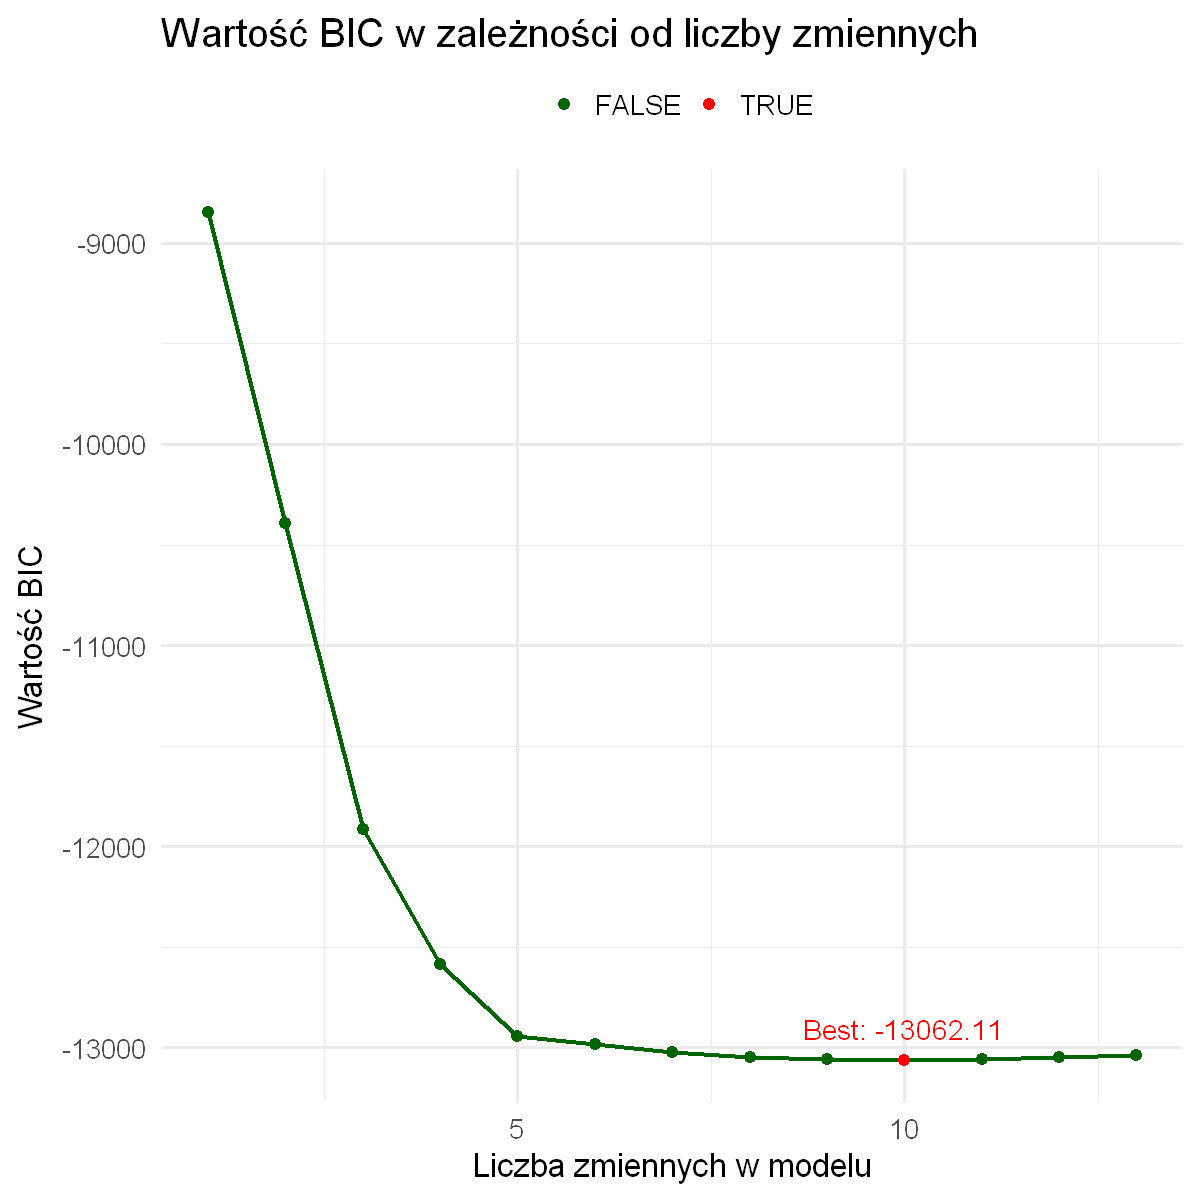

In [36]:
bic_df <- data.frame(
  LiczbaZmiennych = 1:length(elo_bs_sum$bic),
  BIC = elo_bs_sum$bic
)

bic_df$Najlepszy <- FALSE
bic_df$Najlepszy[bic_min] <- TRUE

ggplot(bic_df, aes(x = LiczbaZmiennych, y = BIC)) +
  geom_line(color = "darkgreen", size = 1.2) +
  geom_point(aes(color = Najlepszy), size = 3) +
  scale_color_manual(values = c("FALSE" = "darkgreen", "TRUE" = "red")) +
  labs(
    title = "Wartość BIC w zależności od liczby zmiennych",
    x = "Liczba zmiennych w modelu",
    y = "Wartość BIC",
    color = ""
  ) +
  theme_minimal(base_size = 20) +
  theme(legend.position = "top") +
  geom_text(
    data = subset(bic_df, Najlepszy),
    aes(label = paste0("Best: ", round(BIC, 2))),
    vjust = -1,
    color = "red",
    size = 6
  )

Według kryterium BIC, najlepszy model możemy osiągnąć wykorzystując 10 cech. Poniżej wypisane zostały owe cechy wraz ze współczynnikami modelu regresji liniowej wykorzystującego dane cechy do predykcji wartości rankingu gracza (elo):

In [21]:
coefficients <- coef(elo_bs, id = bic_min)

coef_df <- data.frame(
  Variable = names(coefficients),
  Coefficient = as.numeric(coefficients),
  row.names = NULL
)

kable(coef_df, caption = "Współczynniki w najlepszym modelu (na podstawie BIC)")



Table: Współczynniki w najlepszym modelu (na podstawie BIC)

|Variable           | Coefficient|
|:------------------|-----------:|
|(Intercept)        | 1848.259121|
|avg_moves          |   15.898998|
|avg_cp_loss        |   -4.749684|
|avg_inacc          |  -18.675039|
|avg_mist           |   17.549193|
|avg_blund          | -120.851638|
|frac_time_loss     |  114.836646|
|avg_time_good      |  -13.799206|
|avg_time_blund     |    2.065997|
|avg_mat_imb_per_mv |  -72.468619|
|avg_book_moves     |   49.324419|

Powyższa analiza została wykonana w oparciu o metrykę BIC. Teraz wykonamy podobną analizę, ale wykorzystując poprawione $R^2$ jako metrykę główną. Warto zaznaczyć, iż w przypadku metryki opartej o poprawione $R^2$ najlepszy model to ten, który <u>maksymalizuje</u> wartość metryki.

In [26]:
adjr2_max <- which.max(elo_bs_sum$adjr2)

cat(paste("Best model according to Adjusted R² is model number:", adjr2_max, "\n"))
cat(paste("Maximum Adjusted R² value:", elo_bs_sum$adjr2[adjr2_max]))

Best model according to Adjusted R² is model number: 13 
Maximum Adjusted R² value: 0.731641578268444

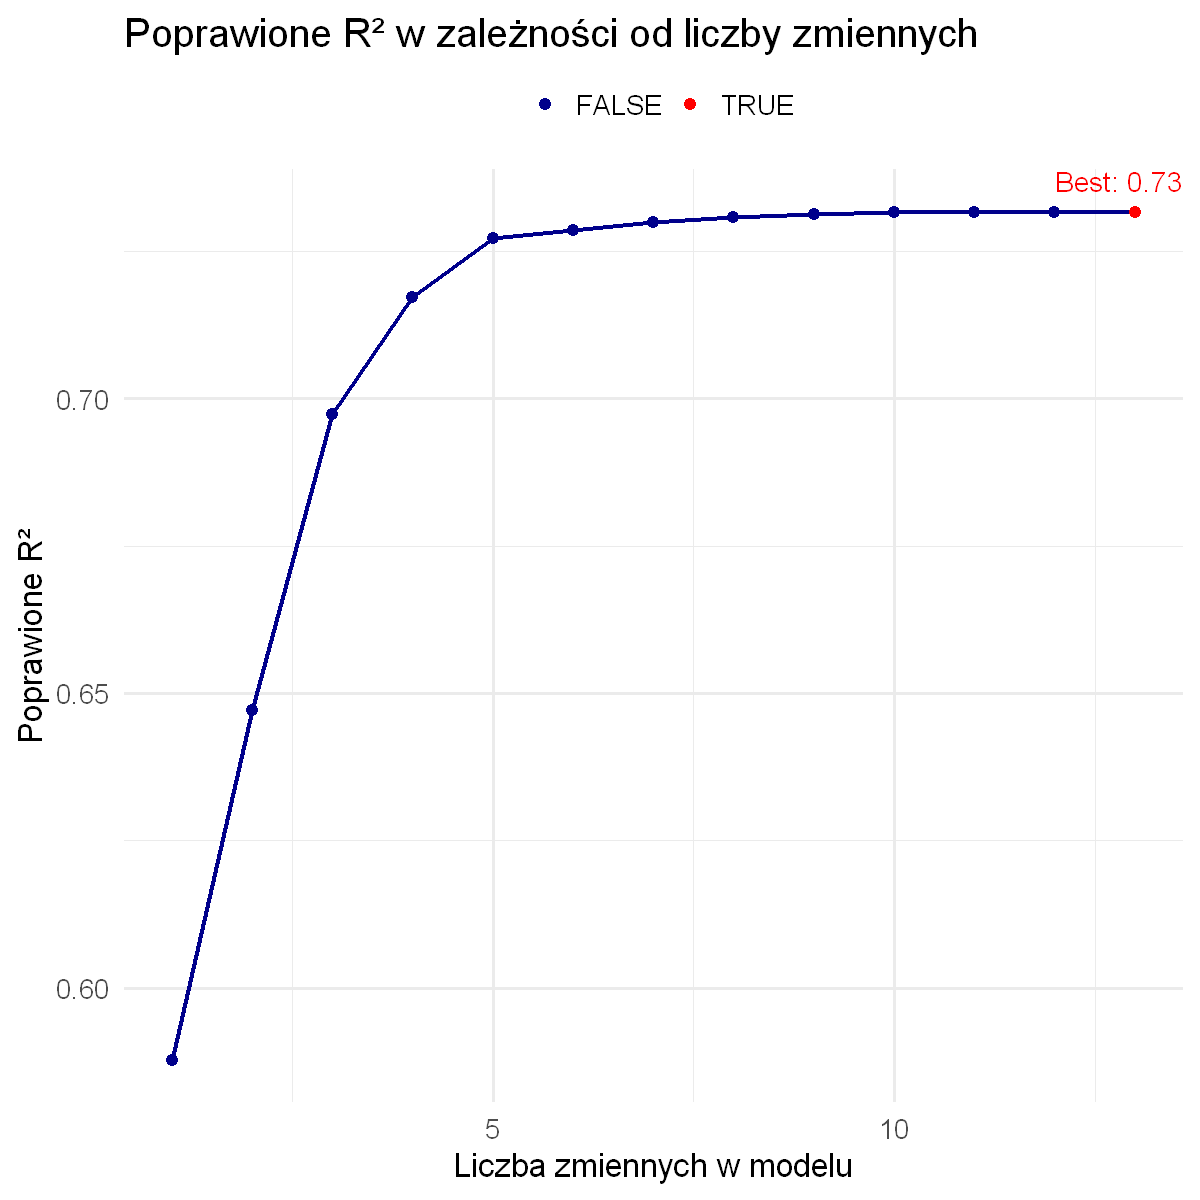

In [35]:
adjr2_df <- data.frame(
  NumVariables = 1:length(elo_bs_sum$adjr2),
  AdjustedR2 = elo_bs_sum$adjr2
)

adjr2_df$Best <- FALSE
adjr2_df$Best[adjr2_max] <- TRUE

ggplot(adjr2_df, aes(x = NumVariables, y = AdjustedR2)) +
  geom_line(color = "darkblue", size = 1.2) +
  geom_point(aes(color = Best), size = 3) +
  scale_color_manual(values = c("FALSE" = "darkblue", "TRUE" = "red")) +
  labs(
    title = "Poprawione R² w zależności od liczby zmiennych",
    x = "Liczba zmiennych w modelu",
    y = "Poprawione R²",
    color = ""
  ) +
  theme_minimal(base_size = 20) +
  theme(legend.position = "top") +
  geom_text(
    data = subset(adjr2_df, Best),
    aes(label = paste0("Best: ", round(AdjustedR2, 4))),
    vjust = -1,
    color = "red",
    size = 6
  )

Jak widać w przypadku metryki poprawionego $R^2$, w przeciwieństwie do metryki BIC, najlepszym modelem jest ten z maksymalną możliwą liczbą cech ($13$). Warto jednak zauważyć, że kształt krzywej w obydwu przypadkach jest podobny, tylko odbity symetrycznie w pionie (maksymalizujemy zamiast minimalizować).

In [38]:
coefficients <- coef(elo_bs, id = adjr2_max)

coef_df <- data.frame(
  Variable = names(coefficients),
  Coefficient = as.numeric(coefficients),
  row.names = NULL
)

kable(coef_df, caption = "Współczynniki w najlepszym modelu (na podstawie poprawionego R^2)")



Table: Współczynniki w najlepszym modelu (na podstawie poprawionego R^2)

|Variable           |  Coefficient|
|:------------------|------------:|
|(Intercept)        | 1858.0955764|
|avg_moves          |   16.3030771|
|frac_nonterm       |  -22.5248999|
|avg_cp_loss        |   -4.8413284|
|avg_inacc          |  -17.8468392|
|avg_mist           |   18.3452756|
|avg_blund          | -120.7608131|
|frac_time_win      |  -27.1943422|
|frac_time_loss     |  101.2796385|
|avg_time_good      |  -12.8773461|
|avg_time_inaccm    |    0.8363527|
|avg_time_blund     |    2.1446785|
|avg_mat_imb_per_mv |  -73.1492881|
|avg_book_moves     |   49.0308218|

Analizując współczynniki obu najlepszych modeli — wybranego na podstawie kryterium BIC oraz poprawionego $R²$ — można zauważyć, że oba modele mają wiele wspólnych cech, ale również pewne różnice w uwzględnionych zmiennych. Wspólne dla obu modeli jest silne dodatnie znaczenie zmiennej ```avg_moves```, co wskazuje, że wzrost średniej liczby ruchów wiąże się ze wzrostem wartości przewidywanej zmiennej zależnej. Z kolei zmienne takie jak ```avg_cp_loss```, ```avg_inacc```, ```avg_blund``` oraz ```avg_mat_imb_per_mv``` mają ujemne współczynniki, co sugeruje, że większe wartości tych cech negatywnie wpływają na wynik. W obu modelach dodatnio wpływa na wynik avg_mist, a także avg_book_moves. Warto zauważyć, że model oparty na poprawionym $R²$ zawiera więcej zmiennych, w tym ```frac_nonterm``` i ```frac_time_win```, które mają odpowiednio ujemne współczynniki, co może wskazywać na dodatkowe aspekty wpływające na wynik, nieujęte w modelu BIC. Zmienna ```frac_time_loss``` ma w obu modelach dodatni i stosunkowo duży współczynnik, co sugeruje, że większy udział czasu zużywanego w przegranych partiach jest skorelowany ze wzrostem wartości przewidywanego rankingu gracza. Zmienna ```avg_time_good``` wykazuje negatywny wpływ w obu modelach, co może oznaczać, że większa średnia czasu poświęcanego na dobre ruchy wiąże się z niższym wynikiem. Ogólnie oba modele wskazują na znaczenie zarówno aspektów jakościowych (np. błędy, niedokładności), jak i czasowych w predykcji analizowanego wyniku, z modelem opartym na poprawionym R² rozszerzonym o dodatkowe czynniki mogące lepiej tłumaczyć zmienność danych.

### 5.4 Selekcja krokowa do przodu i wstecz

In [40]:
# Forward selection
elo_fwd <- regsubsets(elo ~ ., data = data_train, nvmax = n_features, method = "forward")
elo_fwd_sum <- summary(elo_fwd)
cat("Podsumowanie modelu forward stepwise:\n")
print(elo_fwd_sum)

# Backward elimination
elo_back <- regsubsets(elo ~ ., data = data_train, nvmax = n_features, method = "backward")
elo_back_sum <- summary(elo_back)
cat("\n\nPodsumowanie modelu backward stepwise:\n")
print(elo_back_sum)

Podsumowanie modelu forward stepwise:
Subset selection object
Call: regsubsets.formula(elo ~ ., data = data_train, nvmax = n_features, 
    method = "forward")
13 Variables  (and intercept)
                   Forced in Forced out
avg_moves              FALSE      FALSE
frac_nonterm           FALSE      FALSE
avg_cp_loss            FALSE      FALSE
avg_inacc              FALSE      FALSE
avg_mist               FALSE      FALSE
avg_blund              FALSE      FALSE
frac_time_win          FALSE      FALSE
frac_time_loss         FALSE      FALSE
avg_time_good          FALSE      FALSE
avg_time_inaccm        FALSE      FALSE
avg_time_blund         FALSE      FALSE
avg_mat_imb_per_mv     FALSE      FALSE
avg_book_moves         FALSE      FALSE
1 subsets of each size up to 13
Selection Algorithm: forward
          avg_moves frac_nonterm avg_cp_loss avg_inacc avg_mist avg_blund
1  ( 1 )  " "       " "          "*"         " "       " "      " "      
2  ( 1 )  " "       " "          "*"     

In [75]:
bic_min_fwd <- which.min(elo_fwd_sum$bic)
cp_min_fwd <- which.min(elo_fwd_sum$cp)
adjr2_max_fwd <- which.max(elo_fwd_sum$adjr2)

cat("Selektcja krokowa FORWARD:\n")
cat("Najlepszy model wg BIC: liczba zmiennych =", bic_min_fwd, ", BIC =", round(elo_fwd_sum$bic[bic_min_fwd], 2), "\n")
cat("Najlepszy model wg Cp: liczba zmiennych =", cp_min_fwd, ", Cp =", round(elo_fwd_sum$cp[cp_min_fwd], 2), "\n")
cat("Najlepszy model wg poprawionego R²: liczba zmiennych =", adjr2_max_fwd, ", Adj. R² =", round(elo_fwd_sum$adjr2[adjr2_max_fwd], 4), "\n\n")

# Find optimal models according to given criterion
bic_min_back <- which.min(elo_back_sum$bic)
cp_min_back <- which.min(elo_back_sum$cp)
adjr2_max_back <- which.max(elo_back_sum$adjr2)

cat("Selektcja krokowa BACKWARD:\n")
cat("Najlepszy model wg BIC: liczba zmiennych =", bic_min_back, ", BIC =", round(elo_back_sum$bic[bic_min_back], 2), "\n")
cat("Najlepszy model wg Cp: liczba zmiennych =", cp_min_back, ", Cp =", round(elo_back_sum$cp[cp_min_back], 2), "\n")
cat("Najlepszy model wg poprawionego R²: liczba zmiennych =", adjr2_max_back, ", Adj. R² =", round(elo_back_sum$adjr2[adjr2_max_back], 4), "\n\n")

# Compare selected models
cat("Porównanie wybranych modeli (liczba zmiennych):\n")
cat("BIC: forward =", bic_min_fwd, ", backward =", bic_min_back, "\n")
cat("Cp: forward =", cp_min_fwd, ", backward =", cp_min_back, "\n")
cat("Adjusted R²: forward =", adjr2_max_fwd, ", backward =", adjr2_max_back, "\n")

Selektcja krokowa FORWARD:
Najlepszy model wg BIC: liczba zmiennych = 11 , BIC = -13053.89 
Najlepszy model wg Cp: liczba zmiennych = 12 , Cp = 13.52 
Najlepszy model wg poprawionego R²: liczba zmiennych = 13 , Adj. R² = 0.7316 

Selektcja krokowa BACKWARD:
Najlepszy model wg BIC: liczba zmiennych = 10 , BIC = -13062.11 
Najlepszy model wg Cp: liczba zmiennych = 11 , Cp = 12.5 
Najlepszy model wg poprawionego R²: liczba zmiennych = 13 , Adj. R² = 0.7316 

Porównanie wybranych modeli (liczba zmiennych):
BIC: forward = 11 , backward = 10 
Cp: forward = 12 , backward = 11 
Adjusted R²: forward = 13 , backward = 13 


Wyniki selekcji krokowej w przód i wstecz wskazują, że oba podejścia często wybierają podobną liczbę zmiennych jako optymalną według kryteriów $BIC$, $C_p$ i poprawionego $R²$, co świadczy o stabilności i spójności modelu. Jednak różnice między kryteriami pokazują kompromis między prostotą modelu (preferowaną przez $BIC$) a dopasowaniem (mierzone przez poprawione $R²$).

### 5.5 Wybór modelu przy pomocy metody zbioru walidacyjnego

Zaczynamy od podzielenia zbioru treningowego na dwa podzbiory: właściwy zbiór uczący i zbiór walidacyjny.

In [61]:
n_samples <- nrow(data_train)

train_idx <- sample(n_samples, n_samples / 2)
val_idx <- setdiff(1:n_samples, train_idx)

Teraz przeprowadzamy selekcję z użyciem zbioru uczącego, a ewaluowaną na zbiorze walidacyjnym.

In [57]:
elo_bs_v <- regsubsets(elo ~ ., data = data_train[train_idx,], nvmax = n_features)

In [58]:
predict.regsubsets <- function(object, newdata, id, ...) {
  model_formula <- as.formula(object$call[[2]])
  mat <- model.matrix(model_formula, newdata)
  coefs <- coef(object, id = id)
  mat[, names(coefs)] %*% coefs
}

prediction_error <- function(i, model, subset) {
  pred <- predict(model, data_train[subset,], id = i)
  mean((data_train$elo[subset] - pred)^2)
}

In [ ]:
val_errors <- sapply(1:n_features, prediction_error, model = elo_bs_v, subset = val_idx)
val_errors

[1] 64180.33 55132.76 47401.18 44521.16 42789.22 42669.17 42451.42 42268.27
 [9] 42209.23 42136.31 42142.38 42145.05 42145.14

In [66]:
optimal_num_vars <- which.min(val_errors)
cat("Model optymalny zawiera", optimal_num_vars, "zmiennych.\n")

Model optymalny zawiera 10 zmiennych.


Po znalezieniu optymalnej liczby zmiennych, trenujemy optymalny model regresji, używając wszystkich przykładów dostępnych w zbiorze treningowym:

In [72]:
final_model <- regsubsets(elo ~ ., data = data_train, nvmax = optimal_num_vars, method = "backward")
final_summary <- summary(final_model)

coefs <- coef(final_model, id = optimal_num_vars)
coefs_df <- data.frame(
  Variable = names(coefs),
  Coefficient = as.numeric(coefs)
)

kable(coefs_df, caption = "Współczynniki w najlepszym modelu (na podstawie oceny na zbiorze walidacyjnym)")



Table: Współczynniki w najlepszym modelu (na podstawie oceny na zbiorze walidacyjnym)

|Variable           | Coefficient|
|:------------------|-----------:|
|(Intercept)        | 1848.259121|
|avg_moves          |   15.898998|
|avg_cp_loss        |   -4.749684|
|avg_inacc          |  -18.675039|
|avg_mist           |   17.549193|
|avg_blund          | -120.851638|
|frac_time_loss     |  114.836646|
|avg_time_good      |  -13.799206|
|avg_time_blund     |    2.065997|
|avg_mat_imb_per_mv |  -72.468619|
|avg_book_moves     |   49.324419|

Jest to model tożsamy z tym, jaki uzyskaliśmy wcześniej na bazie porównań z użyciem metryki BIC.

### 5.6 Wybór modelu przy pomocy k-krotnej walidacji krzyżowej

Wybór modelu z użyciem k-krotnej walidacji krzyżowej jest uogólnieniem podejścia opartego na jednym zbiorze walidacyjnym, ponieważ zamiast oceniać model tylko na jednej, stałej części danych, k-krotna walidacja dzieli dane na k różnych podzbiorów i kolejno używa każdego z nich jako zbioru walidacyjnego, podczas gdy pozostałe służą do trenowania modelu. Dzięki temu ocena modelu jest bardziej stabilna i mniej podatna na losowy podział danych, co prowadzi do bardziej wiarygodnego wyboru optymalnego modelu.

In [77]:
k <- 10
folds <- sample(1:k, n_samples, replace = TRUE)

val_err <- NULL
for (j in 1:k) {
  fit_bs <- regsubsets(elo ~ ., data = data_train[folds != j,], nvmax = n_features)
  err <- sapply(1:n_features, prediction_error, model = fit_bs, subset = (folds == j))
  val_err <- rbind(val_err, err)
}

In [81]:
cv_errors_df <- data.frame(
  LiczbaZmiennych = 1:length(cv_errors),
  BladWalidacji = cv_errors
)

kable(cv_errors_df, caption = "Błąd walidacji w zależności od liczby zmiennych")



Table: Błąd walidacji w zależności od liczby zmiennych

| LiczbaZmiennych| BladWalidacji|
|---------------:|-------------:|
|               1|      62796.33|
|               2|      53806.53|
|               3|      46173.29|
|               4|      43155.91|
|               5|      41618.62|
|               6|      41422.53|
|               7|      41215.69|
|               8|      41102.15|
|               9|      41037.22|
|              10|      40992.04|
|              11|      41006.61|
|              12|      41010.87|
|              13|      40995.39|

Widzimy, iż ponownie optymalnym modelem okazuje się być model z 10 zmiennymi niezależnymi. Ponieważ model ten był już wcześniej kilkukrotnie prezentowany, nie ma potrzeby tworzyć go po raz kolejny. Oba podejścia – BIC, które karze za nadmierną złożoność modelu, oraz k-krotna walidacja krzyżowa, która ocenia model na niezależnych podzbiorach danych – wskazują na podobny kompromis między dopasowaniem a prostotą modelu. Innymi słowy, potwierdza to stabilność i wiarygodność wyboru optymalnej liczby cech, sugerując, że wybrany model dobrze generalizuje na nowe dane i nie jest ani zbyt prosty, ani zbyt złożony.